In [102]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import train_v42 as weartrain
from wearables.scripts import eval_v42 as weareval
from wearables.scripts import model as wearmodels

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [2]:
# load data

model_fp = '/home/ngrav/project/wearables/model_zoo'

bst_trainer = os.path.join(model_fp, 'trainer_cnnv43l1l2_GA5.pkl')
bst_modelpkl = os.path.join(model_fp, '6143-cnnv43l1l2_GA5.pkl')


In [3]:
# fix potential issue with net
net = wearmodels.CNN(2, 10080, 1, [(1, 32), (1, 64), (1, 128), (3, 256)])

# best CNN
with open(bst_trainer, 'rb') as f:
    trainer = pickle.load(f)
    f.close()

# fix issue with net
trainer.model = net

# call eval to get output, modify for return_hidden = True option
evaluation = weareval.eval_trained(trainer, split='train',
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [132]:
evaluation = weareval.eval_trained(trainer, 
                                   modelpkl=bst_modelpkl,
                                   two_outputs=True)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


KeyboardInterrupt: 

# fastdtw graph

1. D --> annoy --> clustering (unsupervised), then association with metadata
2. self-supervised embedding (~512dimensions) --> annoy based on D with various distance metrics OR DL based clustering, then association with metadata vs. GA association with metadata (otherwise, what is novel about the groups... do subclusters identify new interesting patients?)
3. 

In [15]:
from wearables.scripts import DTW as weardtw

In [ ]:
data_dtw = weardtw.rawdata_umap_dtw(bst_trainer)


Starting pdist calculation


In [ ]:
# since this takes so long, save it
with open('/home/ngrav/scratch/data_dtw.pkl', 'wb') as f:
    pickle.dump(data_dtw, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

In [5]:
# load it 
with open('/home/ngrav/scratch/data_dtw.pkl', 'rb') as f:
    data_dtw = pickle.load(f)
    f.close()

In [112]:
import importlib
importlib.reload(weardtw)

<module 'wearables.scripts.DTW' from '/home/ngrav/project/wearables/scripts/DTW.py'>

In [17]:
# rerun umap, forgot to return data
data_dtw['data_umap'] = weardtw.embed(data_dtw['D'])

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [18]:
data_umap = data_dtw['data_umap']
md = data_dtw['md']

Text(0, 0.5, 'UMAP2')

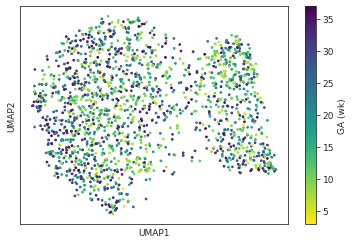

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
im = ax.scatter(data_umap[:, 0], data_umap[:, 1], 
                s=3,
                c=md['GA'], cmap='viridis_r')
fig.colorbar(im, label='GA (wk)')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

In [113]:
D = data_dtw['D']
membership = weardtw.leiden_clustering(D, gamma=0.5)


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'UMAP2')

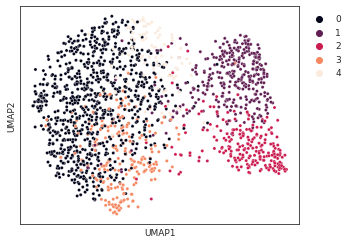

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.scatterplot(data_umap[:, 0], data_umap[:, 1], 
                s=10,
                hue=membership,
                palette='rocket',
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

In [130]:
md.index

Index(['2280_22', '2537_14', '2440_34', '1849_14', '1604_11', '1405_20',
       '1186_35', '2571_16', '2308_24', '1528_30',
       ...
       '2177_34', '1679_12', '1222_7', '2329_33', '2013_30', '2469_24',
       '1649_24', '2409_7', '1085_8', '2464_14'],
      dtype='object', length=1729)

In [129]:
md.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,edinb3_1trim,edinb4_1trim,edinb5_1trim,edinb6_1trim,edinb7_1trim,edinb8_1trim,edinb9_1trim,edinb10_1trim,GA,actigraphy-GA
2280_22,2280,26.0,1.0,3.0,3.0,0.0,0.0,35.061237,1.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,22.0,NaN
2537_14,2537,35.0,1.0,2.0,3.0,0.0,0.0,26.998709,0.0,0.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,NaN
2440_34,2440,29.0,1.0,2.0,3.0,0.0,0.0,21.922123,0.0,1.0,...,3.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,34.0,NaN
1849_14,1849,29.0,0.0,2.0,1.0,0.0,1.0,34.944042,0.0,0.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,NaN
1604_11,1604,18.0,0.0,2.0,2.0,1.0,1.0,22.878698,0.0,1.0,...,1.0,4.0,3.0,2.0,1.0,1.0,3.0,1.0,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469_24,2469,30.0,0.0,1.0,3.0,0.0,0.0,21.831446,0.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,24.0,NaN
1649_24,1649,27.0,0.0,3.0,1.0,0.0,1.0,26.754021,1.0,1.0,...,3.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,24.0,NaN
2409_7,2409,31.0,1.0,2.0,3.0,0.0,0.0,28.490723,0.0,1.0,...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,7.0,NaN
1085_8,1085,33.0,0.0,2.0,1.0,0.0,0.0,36.955338,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,NaN


In [125]:
md.loc[evaluation.id, 'actigraphy-GA'] = evaluation.yhat.numpy()

KeyError: "None of [Index(['2560_8', '2620_24', '2367_34', '2259_34', '2053_20', '1281_33',\n       '2397_9', '2595_11', '1522_13', '2362_24',\n       ...\n       '1375_19', '2058_15', '1130_27', '2251_24', '1576_11', '1020_7',\n       '2568_26', '2512_12', '1046_26', '1062_28'],\n      dtype='object', length=734)] are in the [index]"

In [ ]:
md.head()

In [123]:
evaluation.id

['2560_8',
 '2620_24',
 '2367_34',
 '2259_34',
 '2053_20',
 '1281_33',
 '2397_9',
 '2595_11',
 '1522_13',
 '2362_24',
 '1321_10',
 '2457_34',
 '2323_11',
 '1689_34',
 '1358_10',
 '2622_32',
 '2407_12',
 '2166_13',
 '2262_12',
 '2100_32',
 '2048_26',
 '1281_12',
 '1133_13',
 '1321_27',
 '2248_32',
 '1364_12',
 '1736_32',
 '2591_25',
 '1647_11',
 '1123_11',
 '2255_32',
 '1499_11',
 '2360_12',
 '1533_36',
 '1140_21',
 '2337_8',
 '2075_34',
 '2053_8',
 '2033_8',
 '2441_8',
 '2179_34',
 '2144_34',
 '1036_13',
 '1305_23',
 '2236_34',
 '1658_10',
 '1815_7',
 '2181_11',
 '1421_23',
 '2375_10',
 '2037_24',
 '2112_31',
 '1265_13',
 '2504_35',
 '2180_26',
 '1004_21',
 '2505_35',
 '2413_26',
 '2612_16',
 '2519_14',
 '2179_24',
 '1791_27',
 '2331_12',
 '1555_16',
 '1592_15',
 '1591_24',
 '1020_16',
 '2040_21',
 '2485_8',
 '1025_24',
 '1441_29',
 '2133_32',
 '1187_26',
 '2462_34',
 '1542_12',
 '2160_23',
 '2262_16',
 '2009_8',
 '2480_30',
 '2439_11',
 '1484_20',
 '1249_24',
 '1697_12',
 '1233_19',
 

In [120]:
evaluation.yhat

tensor([24.5285, 20.7769, 22.9962, 25.0036, 21.1296, 14.4618, 20.3230, 21.7818,
        21.7922, 22.3711, 21.1987, 23.7916, 18.6829, 22.2404, 22.2623, 21.8022,
        19.4347, 21.0004,  8.0937, 26.6213, 21.4788, 14.4647, 14.4565, 18.5099,
        22.5390, 18.9971, 22.7520, 17.9238, 24.2617, 24.8182, 18.9730, 19.3099,
        16.2904, 21.9250, 22.8207,  8.2959, 24.9282, 11.8580,  9.8467, 19.6512,
        26.6082, 23.3085, 23.1702, 16.1354, 19.4097, 15.2855, 16.9026, 20.8756,
        20.7025, 13.9527, 26.1351, 22.6204, 19.3211, 23.0983, 21.7408, 17.7577,
        17.9414, 20.1281, 20.1540, 21.5613, 19.2600, 19.2886,  7.2237, 19.5278,
        19.1154, 24.4470, 19.5541, 22.1736, 17.0126, 25.8436, 19.1144, 22.1185,
        22.5359, 24.3284, 16.7033, 21.9945, 20.6586, 14.5522, 20.6938, 17.5756,
        25.8645, 21.8208, 24.8512, 16.8741, 20.9480, 20.2868, 23.3773, 21.2021,
        25.9152, 17.0214, 22.2179, 11.2345, 19.2791, 15.4235, 20.0052, 23.4298,
        25.5936, 12.6076, 19.6219, 25.27

## dev pairwise DTW

**Observations**
- even with `n_jobs=32`, the sklearn implementation is slower than the scipy pdist

In [10]:
def pdtw(mat):
    return pdist(mat, lambda u, v: fastdtw.fastdtw(u, v)[0])

In [8]:
x.shape

torch.Size([64, 2, 10080])

In [11]:
# take only activity
x = x[:, 0, :]
x.shape

torch.Size([64, 10080])

In [14]:
tic = time.time()
d_mb = pdtw(x)
print('{:.0f}s'.format(time.time() - tic))

9s


In [16]:
# compare with paralellized scikit learn pairwise_distances 
from sklearn.metrics.pairwise import pairwise_distances

In [24]:
tic = time.time()
d_mb_sklearn = pairwise_distances(x, metric=lambda u, v: fastdtw.fastdtw(u, v)[0], n_jobs=32)
print('{:.0f}s'.format(time.time() - tic))

22s


In [22]:
print(d_mb.shape)
print(d_mb_sklearn.shape)

(2016,)
(64, 64)




## tshoot slow eval

attempts:
- tried to change num_workers of the dataloader to 1, in case there was some problem with the leaking. This did not solve the problem of the thing getting stuck after batch 1 loading
- tried changing pin_memory=False for the dataloader. This got through one additional batch loading but stopped on the third (test needs to go through ~11 batches)
- combination of both solved issue. After trying ablation again, getting rid of `dataloader.num_workers = 1` causes a pause. Then changing `dataloader.pin_memory = False` but keeping `dataloader.num_woerkers = 1` makes the eval fast again. SO, the issue was indeed the num_workers